In [20]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

In [21]:
data = []
labels = []
file_name = []

# Ganti path sesuai struktur folder kamu
dataset_path = "Dataset/"

# Loop setiap sub-folder (label)
for sub_folder in os.listdir(dataset_path):
    sub_folder_path = os.path.join(dataset_path, sub_folder)
    
    # Pastikan ini folder
    if os.path.isdir(sub_folder_path):
        sub_folder_files = os.listdir(sub_folder_path)
        for filename in sub_folder_files:
            img_path = os.path.join(sub_folder_path, filename)
            img = cv.imread(img_path)
            
            if img is not None:
                img = img.astype(np.uint8)
                # Resize all images to 256x256 for consistency
                img = cv.resize(img, (256, 256))
                
                data.append(img)
                labels.append(sub_folder)
                name = os.path.splitext(filename)[0]
                file_name.append(filename)

# Ubah ke array numpy
data = np.array(data)
labels = np.array(labels)

# Tampilkan info
print("Jumlah gambar:", len(data))
print("Label unik:", np.unique(labels))

Jumlah gambar: 280
Label unik: ['DefectFree' 'DefectHoles' 'DefectLines' 'DefectStain']


In [22]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  280
Data setelah augmentasi:  0


In [ ]:
def manual_grayscale(img_bgr):
    b = img_bgr[:, :, 0].astype(float)
    g = img_bgr[:, :, 1].astype(float)
    r = img_bgr[:, :, 2].astype(float)
    gray = 0.114 * b + 0.587 * g + 0.299 * r
    return gray.astype(np.uint8)

def thresholding(img, threshold):
    result = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > threshold:
                result[i, j] = 0
            else:
                result[i, j] = 1
    return result

def operasiThickening(image):
    output = image.copy()
    m, n = image.shape
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if image[i, j] == 0:
                neighbors = [
                    image[i-1, j-1], image[i-1, j], image[i-1, j+1],
                    image[i, j-1],                 image[i, j+1],
                    image[i+1, j-1], image[i+1, j], image[i+1, j+1]
                ]
                if sum(neighbors) >= 1:
                    output[i, j] = 1
    return output

def Modus(image, y, x):
    padding_size = y // 2
    padded_arr = np.pad(image, padding_size, mode='edge')
    
    copy_arr = np.zeros_like(image).astype(np.float32)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            slice_arr = (padded_arr[i:i + y, j:j + x] / (y * x))
            modus = modusOprt(slice_arr.flatten())
            copy_arr[i, j] = modus[0]
    return copy_arr

def convEdge(kernel, img):
        result = np.zeros_like(img)
        pad_height, pad_width = img.shape
        kernel_height, kernel_width = kernel.shape
        for i in range(pad_height - kernel_height + 1):
            for j in range(pad_width - kernel_width + 1):
                result[i][j] = np.sum(img[i:i+kernel_height, j:j+kernel_width] * kernel)
        return result


def prewit(image):
    kPrewittX = np.array([[-1,  0,  1],
                         [-1,  0,  1],
                         [-1,  0,  1]])

    kPrewittY = np.array([[-1, -1, -1],
                         [ 0,  0,  0],
                         [ 1,  1,  1]])

    convPrewittX = convEdge(kPrewittX, image)
    convPrewittY = convEdge(kPrewittY, image)
    result = np.sqrt(convPrewittX ** 2 + convPrewittY ** 2)
    return result

def thresholdb(image, inverted=False):
    result = np.copy(image) 

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if inverted:
                result[i][j] = 255 if result[i][j] >= 85 else 0
            else:
                result[i][j] = 0 if result[i][j] >= 85 else 255
    return result

Pre processing 

In [62]:
dataPreprocessed = []
for i in range(len(data)):  # Loop through each image and do preprocessing
    img = data[i]
    img_gray = manual_grayscale(img)
    img_thresh = thresholding(img_gray, 85)
    img_prewitt = prewit(img_thresh)
    dataPreprocessed.append(img_prewitt)

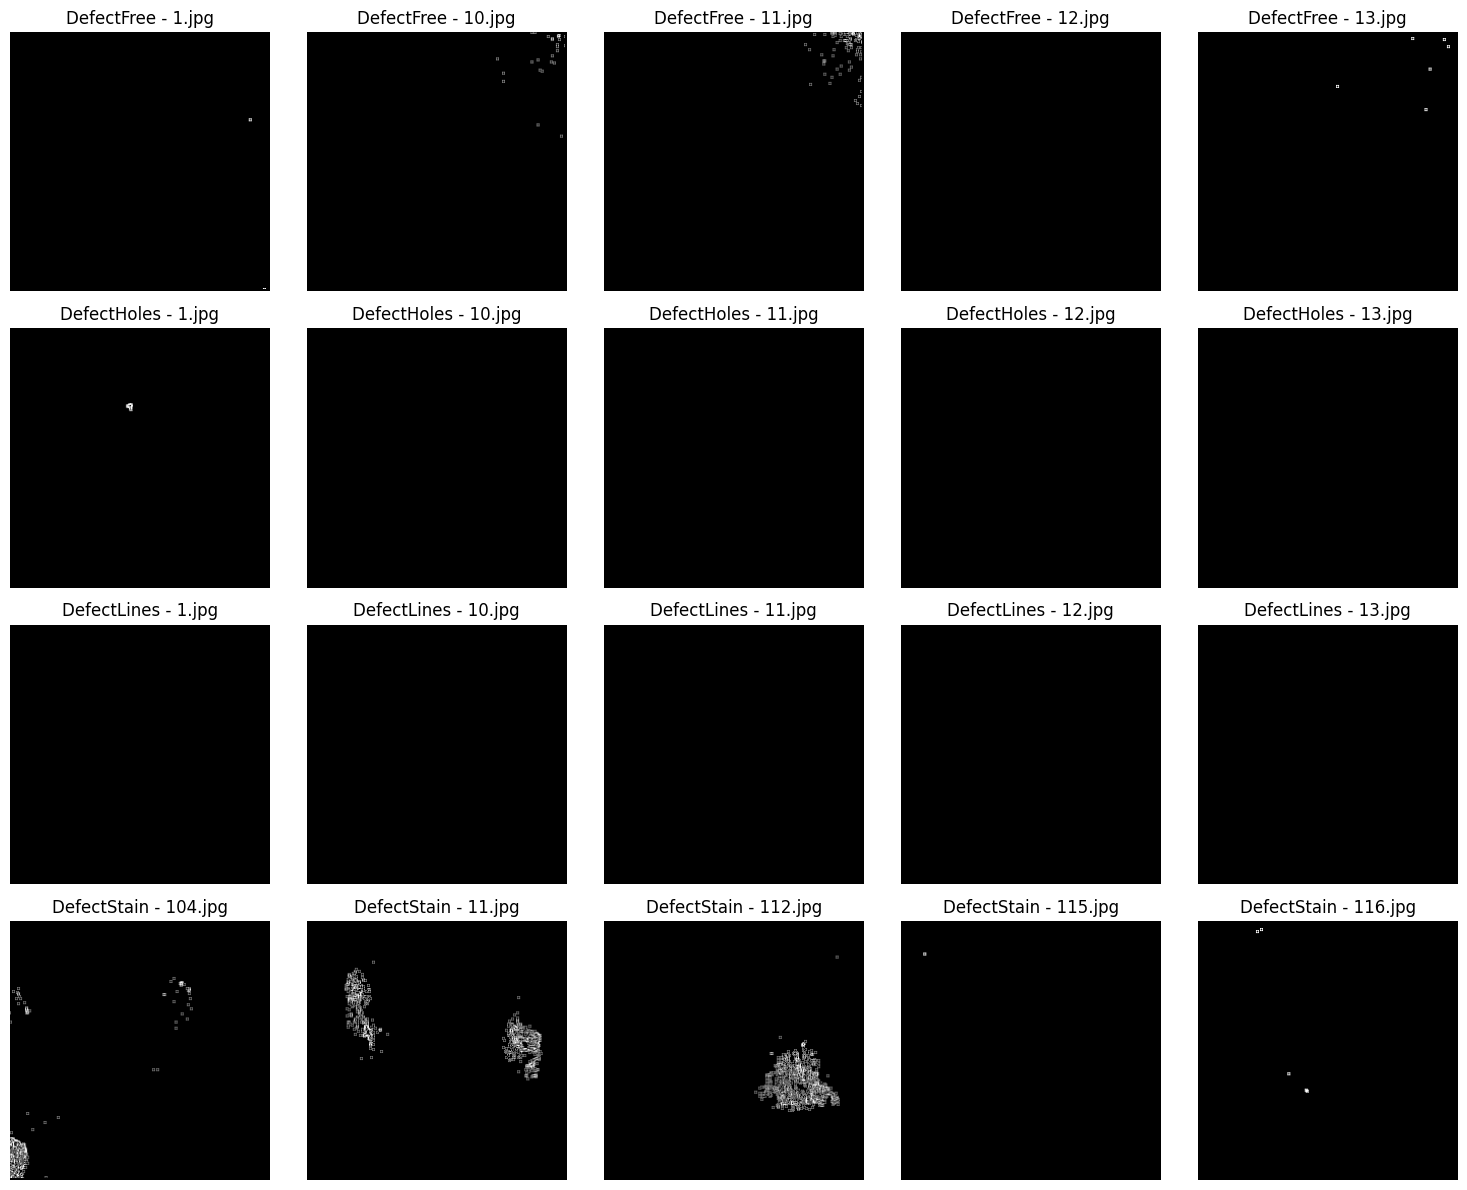

In [63]:
labels_unique = np.unique(labels)
fig, axs = plt.subplots(len(labels_unique), 5, figsize=(15, 3 * len(labels_unique)))

for i, label in enumerate(labels_unique):
    idx = np.where(labels == label)[0][:5]  # Ambil 5 indeks pertama untuk label ini
    if len(idx) == 0:
        for j in range(5):
            axs[i, j].axis('off')
        continue
    for j in range(5):
        if j < len(idx):
            k = idx[j]
            axs[i, j].imshow(dataPreprocessed[k], cmap='gray')
            axs[i, j].set_title(f"{label} - {file_name[k]}")
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()